# Title

Muhammad Ikram Qadri

Project:  ETL, Analysis, and Visualization

# Index

- [1. Import Necessary Python Pacakges](#1.-Import-Necessary-Python-Pacakges)
- [2. Open and Read Excel Workbook in Jupyter Notebook](#2.-Open-and-Excel-workbook-in-Jupyter-Notebook)
- [3. Build ETL Pipeline](#3.-Build-ETL-Pipeline)
    - [3.1. Extract Transfom(ET) of the ETL Process](#3.1.-Extract-Transfom(ET)-of-the-ETL-Process)
    - [3.2. Load(L) of the ETL Process](#3.2.-Load(L)-of-the-ETL-Process)
        - [3.2.1. Execute DDL Logic](#3.2.1.-Execute-DDL-Logic)
        - [3.2.2. Execute DML Logic](#3.2.2.-Execute-DML-Logic)
- [4. Execute DQL Logic](#4.-Execute-DQL-Logic)
- [5. Exploratory Analysis](#5.-Exploratory-Analysis)


[Back to top](#Index)

### 1. Import necessary Python Pacakges

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xlrd
import missingno as msno
import seaborn as sns
from scipy.stats import norm
from sqlalchemy import create_engine

#import python script for extract transform part of ETL.
import read_sheet as rs


#import python scripts for load part of of ETL
import load_data_ddl as lddl
import load_data_dml as ldml
import read_data_dql as rdql

import warnings
warnings.filterwarnings('ignore')

[Back to top](#Index)

### 2. Open and Read Excel Workbook in Jupyter Notebook


In [2]:
# opne workbook and get names of all sheets

# copy the file_path on your local machine
file_path = 'mrtssales92-present.xls'

workbook = xlrd.open_workbook(file_path)
sheets = workbook.sheet_names()
# sheets[0]


In [3]:
""" 
please delete column P on sheet 2015 for this code to run successfully. 
Althought the that column is empty but probably due to some formatting error the code will thow an error if you
don't delete that column.
"""
frames = []

start_row = 5
end_row = 71
nrows = end_row - start_row

for index in sheets:
    frame = rs.read_sheet(file_path, index, nrows) 
    frames.append(frame)

df = pd.concat(frames)

df.head()

,business_kind,month,amount_million
0,retail_and_food_services_sales_total,2021-01-01,517119.0
1,retail_sales_and_food_services_excl_motor_vehi...,2021-01-01,412864.0
2,retail_sales_and_food_services_excl_gasoline_s...,2021-01-01,479905.0
3,retail_sales_and_food_services_excl_motor_vehi...,2021-01-01,375650.0
4,retail_sales_total,2021-01-01,464362.0


[Back to top](#Index)

### 3. Build ETL Pipeline

Since we have wrangled the data, following we are going to build the ETL pipeline.




#### 3.1. Extract Transfom(ET) of the ETL Process

[Back to top](#Index)

#### 3.2. Load(L) of the ETL Process

[Back to top](#Index)
##### 3.2.1. Execute DDL Logic

In [4]:
lddl.execute_ddl_logic()

ddl logic is executed


[Back to top](#Index)
##### 3.2.2. Execute DML Logic

In [5]:
col = 0

for row in range(df.shape[0]):
    _business_kind = df.iat[row, col]
    _month = df.iat[row, col+1]
    _amount_million = df.iat[row, col+2]

    ldml.execute_dml_logic(_business_kind, _month, _amount_million)

    if row == df.shape[0]-1:
        print('all records are inserted in the db')

all records are inserted in the db


[Back to top](#Index)
### 4. Execute DQL Logic

In this section we are going to run SQL queries through Python that we have run on MySQL Workbench.

In [6]:
table_name = 'estimate_of_monthly_retail_and_food_services_sales'

query = f"""
            SELECT * FROM {table_name} LIMIT 5;
        """

result = rdql.execute_sql_logic(query)
result.head()

,id,business_kind,month,amount_million
0,1,retail_and_food_services_sales_total,2021-01-01,517119.0
1,2,retail_sales_and_food_services_excl_motor_vehi...,2021-01-01,412864.0
2,3,retail_sales_and_food_services_excl_gasoline_s...,2021-01-01,479905.0
3,4,retail_sales_and_food_services_excl_motor_vehi...,2021-01-01,375650.0
4,5,retail_sales_total,2021-01-01,464362.0


In [7]:
query = f"""
            SELECT
	            EXTRACT(year FROM month)                  AS year, 
                COUNT(DISTINCT EXTRACT(month FROM month)) AS month_count 

            FROM
	            {table_name}

            GROUP BY
	            year;
        """


result = rdql.execute_sql_logic(query)
result.head()

,year,month_count
0,1992,12
1,1993,12
2,1994,12
3,1995,12
4,1996,12


In [8]:
# Top years with highest sales
query = f"""
            SELECT
                EXTRACT(year FROM month)    AS year, 
                SUM(amount_million)         AS total_annual_sales 

            FROM
                {table_name}

            GROUP BY
                year

            ORDER BY
                total_annual_sales DESC

            LIMIT
                5;
        """


result = rdql.execute_sql_logic(query)
result.head()

,year,total_annual_sales
0,2020,48690426.0
1,2019,48271693.0
2,2018,46718765.0
3,2017,44883151.0
4,2016,43256220.0


In [9]:
# Top five businesses
query = f"""
            SELECT
                business_kind 		   AS business_kind, 
                SUM(amount_million)    AS total_annual_sales 

            FROM
                {table_name}

            GROUP BY
                business_kind

            ORDER BY
                total_annual_sales DESC

            LIMIT
                5;
        """
result = rdql.execute_sql_logic(query)
result.head()

,business_kind,total_annual_sales
0,retail_and_food_services_sales_total,118993651.0
1,retail_sales_and_food_services_excl_gasoline_s...,108482097.0
2,retail_sales_total,106404341.0
3,retail_sales_and_food_services_excl_motor_vehi...,94183852.0
4,retail_sales_and_food_services_excl_motor_vehi...,83672298.0


[Back to top](#Index)

### 5. Exploratory Analysis

*What is the trend of the retail and food services categories? Can this data be displayed clearly or do you need to adjust some parameters to reduce extraneous details and be able to visualize a clean trend?*

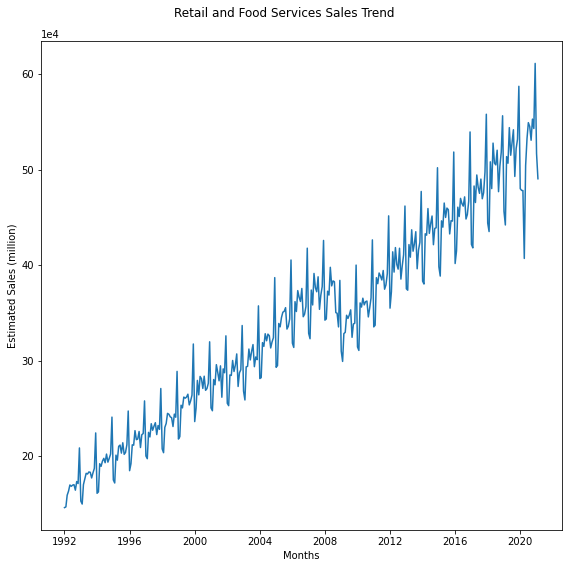

In [10]:
query = f"""
            SELECT
                *
            
            FROM
                {table_name}
            
            WHERE
                business_kind LIKE '%retail_and_food%' 
        """
result = rdql.execute_sql_logic(query)
result.head()



fig, ax = plt.subplots(figsize = (8,8))
sns.lineplot(result.month, result.amount_million)
plt.xlabel('Months')
plt.ylabel('Estimated Sales (million)')
plt.ticklabel_format(style='sci', axis='y', scilimits=(4,4))
plt.suptitle('Retail and Food Services Sales Trend')
plt.tight_layout()
plt.show()

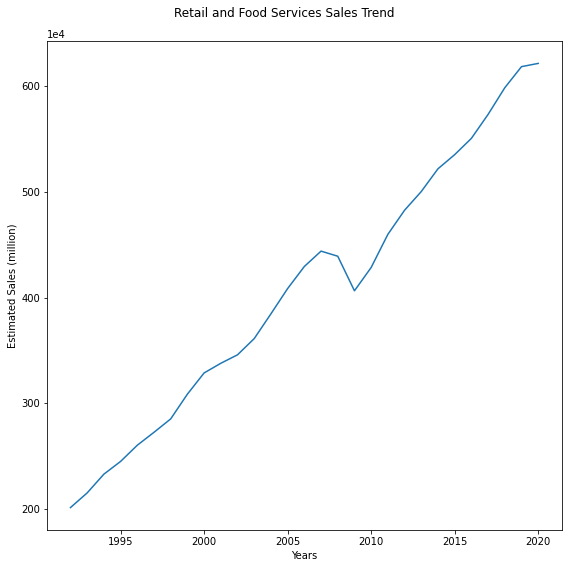

In [11]:
query = f"""
            SELECT
                business_kind, 
                EXTRACT(year FROM month) AS year,
                SUM(amount_million)      AS amount_million
            
            FROM
                {table_name}
            
            WHERE
                business_kind LIKE '%retail_and_food%'
                AND EXTRACT(year FROM month) < 2021
            
            GROUP BY
                year,
                business_kind   
        """
result = rdql.execute_sql_logic(query)
result.head()

fig, ax = plt.subplots(figsize = (8,8))
sns.lineplot(result.year, result.amount_million)
plt.xlabel('Years')
plt.ylabel('Estimated Sales (million)')
plt.ticklabel_format(style='sci', axis='y', scilimits=(4,4))
plt.suptitle('Retail and Food Services Sales Trend')
plt.tight_layout()
plt.show()


*When comparing businesses like bookstores, sporting goods stores, and hobbies, toys, and games stores, what is the highest trend of all of these options? Which one grew faster? Which one is higher? Is there a seasonal pattern? Were there any changes in 2020? Which is better, monthly or yearly?*


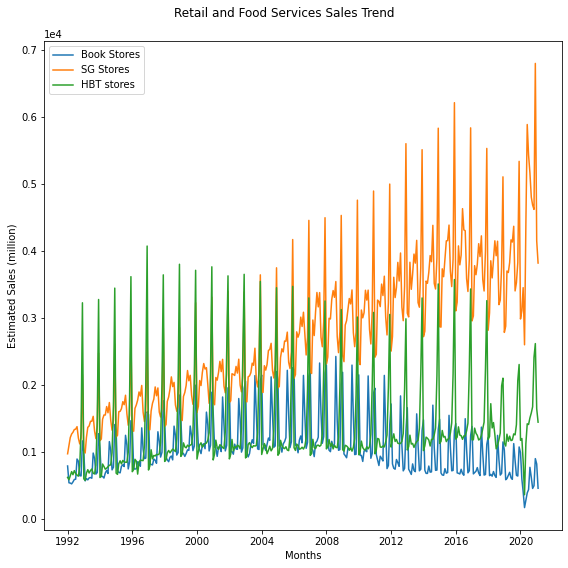

In [12]:
query = f"""
            SELECT
                *
            
            FROM
                {table_name}
            
            WHERE
                business_kind IN ('book_stores', 'sporting_goods_stores','hobby_toy_and_game_stores') 
        """
result = rdql.execute_sql_logic(query)
result.head()

book_stores = result[result['business_kind'] == 'book_stores']
sporting_goods_stores = result[result['business_kind'] == 'sporting_goods_stores']
hobby_toy_and_game_stores = result[result['business_kind'] == 'hobby_toy_and_game_stores']

fig, ax = plt.subplots(figsize = (8,8))

sns.lineplot(book_stores.month, book_stores.amount_million)
sns.lineplot(sporting_goods_stores.month, sporting_goods_stores.amount_million)
sns.lineplot(hobby_toy_and_game_stores.month, hobby_toy_and_game_stores.amount_million)
sns.lineplot()

plt.xlabel('Months')
plt.ylabel('Estimated Sales (million)')
plt.legend(['Book Stores', 'SG Stores', 'HBT stores'])
plt.ticklabel_format(style='sci', axis='y', scilimits=(4,4))
plt.suptitle('Retail and Food Services Sales Trend')
plt.tight_layout()
plt.show()

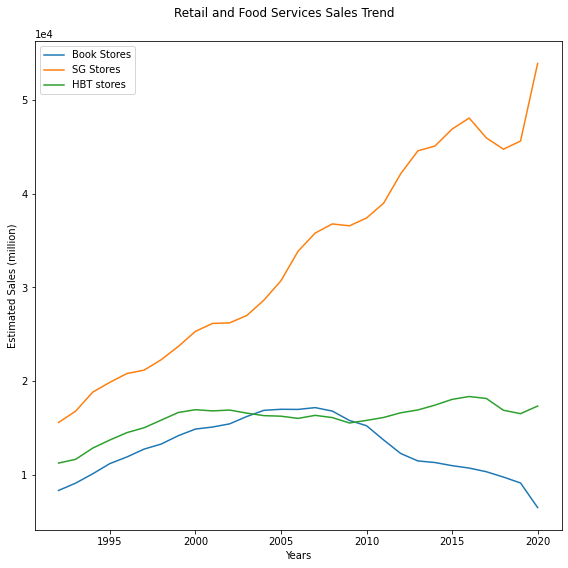

In [13]:
query = f"""
            SELECT
                business_kind, 
                EXTRACT(year FROM month) AS year,
                SUM(amount_million)      AS amount_million
            
            FROM
                {table_name}
            
            WHERE
                business_kind IN ('book_stores', 'sporting_goods_stores','hobby_toy_and_game_stores') 
                AND EXTRACT(year FROM month) < 2021
            
            GROUP BY
                year,
                business_kind
                
        """
result = rdql.execute_sql_logic(query)
result.head()

book_stores = result[result['business_kind'] == 'book_stores']
sporting_goods_stores = result[result['business_kind'] == 'sporting_goods_stores']
hobby_toy_and_game_stores = result[result['business_kind'] == 'hobby_toy_and_game_stores']

fig, ax = plt.subplots(figsize = (8,8))

sns.lineplot(book_stores.year, book_stores.amount_million)
sns.lineplot(sporting_goods_stores.year, sporting_goods_stores.amount_million)
sns.lineplot(hobby_toy_and_game_stores.year, hobby_toy_and_game_stores.amount_million)
sns.lineplot()

plt.xlabel('Years')
plt.ylabel('Estimated Sales (million)')
plt.legend(['Book Stores', 'SG Stores', 'HBT stores'])
plt.ticklabel_format(style='sci', axis='y', scilimits=(4,4))
plt.suptitle('Retail and Food Services Sales Trend')
plt.tight_layout()
plt.show()

*Consider the women's clothing and men's clothing businesses and their percentage change. How are these two businesses related? For each of the two businesses, what is the percentage of contribution to the whole and how does it change over time?*

<function matplotlib.pyplot.show(close=None, block=None)>

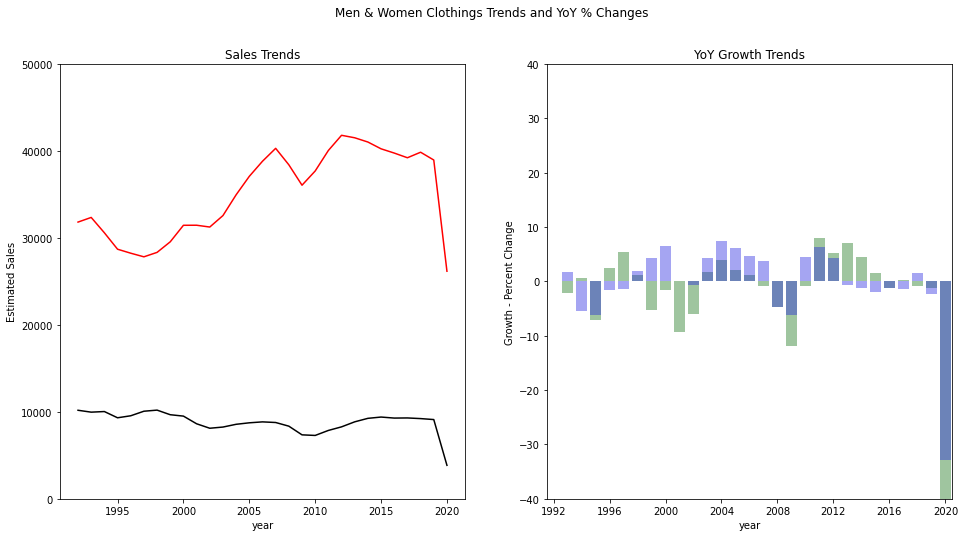

In [14]:
query = f"""
            WITH stg_1 AS(
                SELECT
                    EXTRACT(YEAR FROM month)                              AS year,
                    SUM(CASE
                        WHEN business_kind IN ('mens_clothing_stores')
                        THEN amount_million
                    END)                                                  AS mens_clothing_sales,
                    SUM(CASE
                        WHEN business_kind IN ('womens_clothing_stores')
                        THEN amount_million
                    END)                                                  AS womens_clothing_sales
                
                FROM
                    estimate_of_monthly_retail_and_food_services_sales
                
                GROUP BY
                    year
            ),

            stg_2 AS (  
                SELECT
                    year                                                        AS year,
                    mens_clothing_sales                                         AS mens_clothing_sales_current_year,
                    LAG(mens_clothing_sales) OVER (ORDER BY year)               AS mens_clothing_sales_previous_year,
                    
                    ROUND((mens_clothing_sales - (LAG(mens_clothing_sales) OVER (ORDER BY year)))/
                    LAG(mens_clothing_sales) OVER (ORDER BY year)*100, 2)       AS mens_clothing_year_over_year_perc,
                    
                    womens_clothing_sales                                       AS womens_clothing_sales_current_year,
                    LAG(womens_clothing_sales) OVER (ORDER BY year)             AS womens_clothing_sales_previous_year,
                    
                    ROUND((womens_clothing_sales - (LAG(womens_clothing_sales) OVER (ORDER BY year)))/
                    LAG(womens_clothing_sales) OVER (ORDER BY year)*100, 2)     AS womens_clothing_year_over_year_perc

                FROM
                    stg_1
                
                WHERE
                    year < 2021
            )
            SELECT
                *
            FROM
                stg_2
                
        """
result = rdql.execute_sql_logic(query)
result.head()
years = result.year
mens_clothing_sales = result['mens_clothing_sales_current_year']
womens_clothing_sales = result['womens_clothing_sales_current_year']
mens_clothing_sales_yoy_perc = result['mens_clothing_year_over_year_perc']
womens_clothing_sales_yor_perc = result['womens_clothing_year_over_year_perc']

metrics = [mens_clothing_sales, womens_clothing_sales, mens_clothing_sales_yoy_perc, womens_clothing_sales_yor_perc]

y_lim = [(0, 50000), (-40, 40)]
legends = ['Men\'s Clothing', 'Women\'s Cloting']

fig, axes = plt.subplots(1,2,figsize = (16,8))

colors = ['k', 'r', 'g', 'b']

dummy = 0


for each in range(0,2):
    if each < 1: 
        sns.lineplot(years, metrics[each + dummy], ax = axes[each], color = colors[each + dummy])
        dummy += 1
        sns.lineplot(years, metrics[each + dummy], ax = axes[each], color = colors[each + dummy])
        axes[each].set_ylim(y_lim[each])
        axes[each].set_title('Sales Trends')
        axes[each].set_ylabel('Estimated Sales')
    else:
        sns.barplot(years, metrics[each + dummy], ax = axes[each], color = colors[each + dummy], alpha = 0.4)
        dummy += 1
        sns.barplot(years, metrics[each + dummy], ax = axes[each], color = colors[each + dummy], alpha = 0.4)
        axes[each].set_ylim(y_lim[each])
        axes[each].set_title('YoY Growth Trends')
        axes[each].set_ylabel('Growth - Percent Change')


_xticks = list(range(0, len(years), 4))
plt.xticks(_xticks)
plt.suptitle('Men & Women Clothings Trends and YoY % Changes')
plt.tight_layout
plt.show

*Consider at least two businesses of your own from the MRTS data. Which *queries* did you write to analyze and produce graphs of rolling time windows for the chosen categories?*

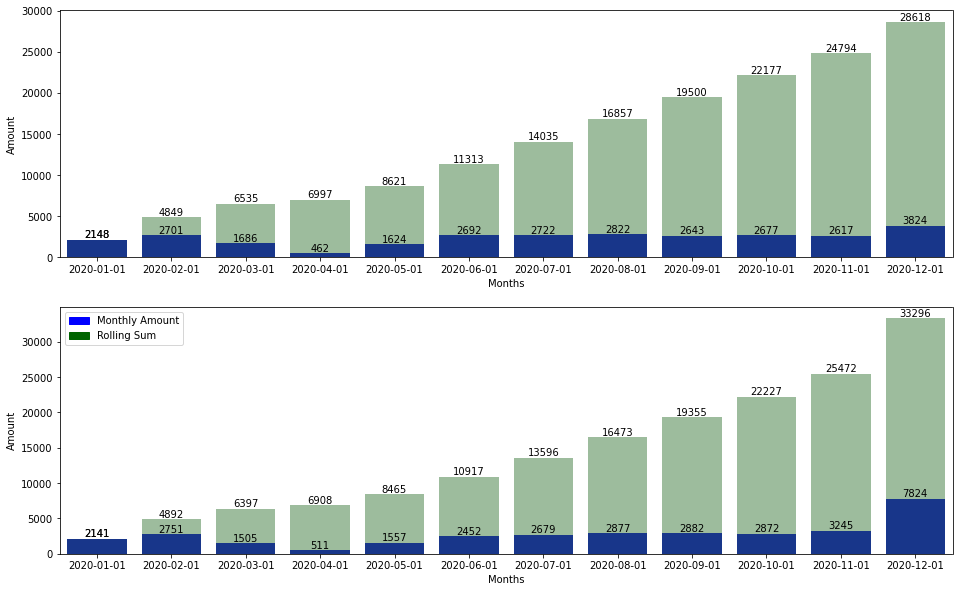

In [15]:
query = """
        SELECT
            month,
            business_kind,
            amount_million AS amount_monthly,
            CASE
                WHEN business_kind IN ('shoe_stores')
                THEN SUM(amount_million) OVER (ORDER BY month)
            END AS amount_rolling_sum

        FROM
            estimate_of_monthly_retail_and_food_services_sales
        WHERE
            business_kind IN ('shoe_stores')
            and EXTRACT(YEAR FROM month) = 2020

        UNION ALL

        SELECT
            month,
            business_kind,
            amount_million AS amount_monthly,
            CASE
                WHEN business_kind IN ('jewelry_stores')
                THEN SUM(amount_million) OVER (ORDER BY month)
            END  AS amount_rolling_sum

        FROM
            estimate_of_monthly_retail_and_food_services_sales
        WHERE
            business_kind IN ('jewelry_stores')
            and EXTRACT(YEAR FROM month) = 2020
        """
result = rdql.execute_sql_logic(query)
result.head()

shoe_stores = result[result['business_kind'] == 'shoe_stores']
shoe_stores = result[result['business_kind'] == 'shoe_stores']
# jewelry_stores = result['womens_clothing_sales_current_year']

metrics = ['shoe_stores','jewelry_stores']

color = ['b', 'r', 'b', 'r']
dummy = 0
fig, axes = plt.subplots(2, 1, figsize=(16,10))

for each in range(0,2):
    ax = axes[each]
    df = result[result['business_kind'] == metrics[each]]
    periodic_amount = df.iloc[:, 2]
    rolling_sum_amount = df.iloc[:, 3]

    bar1 = sns.barplot(df.month,  df.iloc[:,2], color='blue', alpha = 1, ax=ax)
    bar1.bar_label(bar1.containers[0])
    bar2 = sns.barplot(df.month,  df.iloc[:,3], color='darkgreen', alpha =0.4,ax=ax)
    bar2.bar_label(bar2.containers[1])
    # bar2.bar_label(bar2.containers[0])

    # add legend
    top_bar = mpatches.Patch(color='blue', label='Monthly Amount')
    bottom_bar = mpatches.Patch(color='darkgreen', label='Rolling Sum')

    ax.set_xlabel('Months')
    ax.set_ylabel('Amount')
    plt.legend(handles=[top_bar, bottom_bar])
    
plt.show()

*Which one of the businesses considered seems like it's going to attract the least spending? Which business seems likely to attract the most spending?* 


In [16]:
query = f""" 
        SELECT
                business_kind          AS business_kind, 
                SUM(amount_million)    AS total_annual_sales 

            FROM
                estimate_of_monthly_retail_and_food_services_sales

            GROUP BY
                business_kind

            ORDER BY
                total_annual_sales DESC
        """
result = rdql.execute_sql_logic(query)

print('Businesses likely to attract most and least spending are, respectively:')

print(list(result['business_kind'].head(1)))

print(list(result['business_kind'].tail(1)))

Businesses likely to attract most and least spending are, respectively:
['retail_and_food_services_sales_total']
['paint_and_wallpaper_stores']
